In [1]:
%matplotlib inline
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

<IPython.core.display.Javascript object>


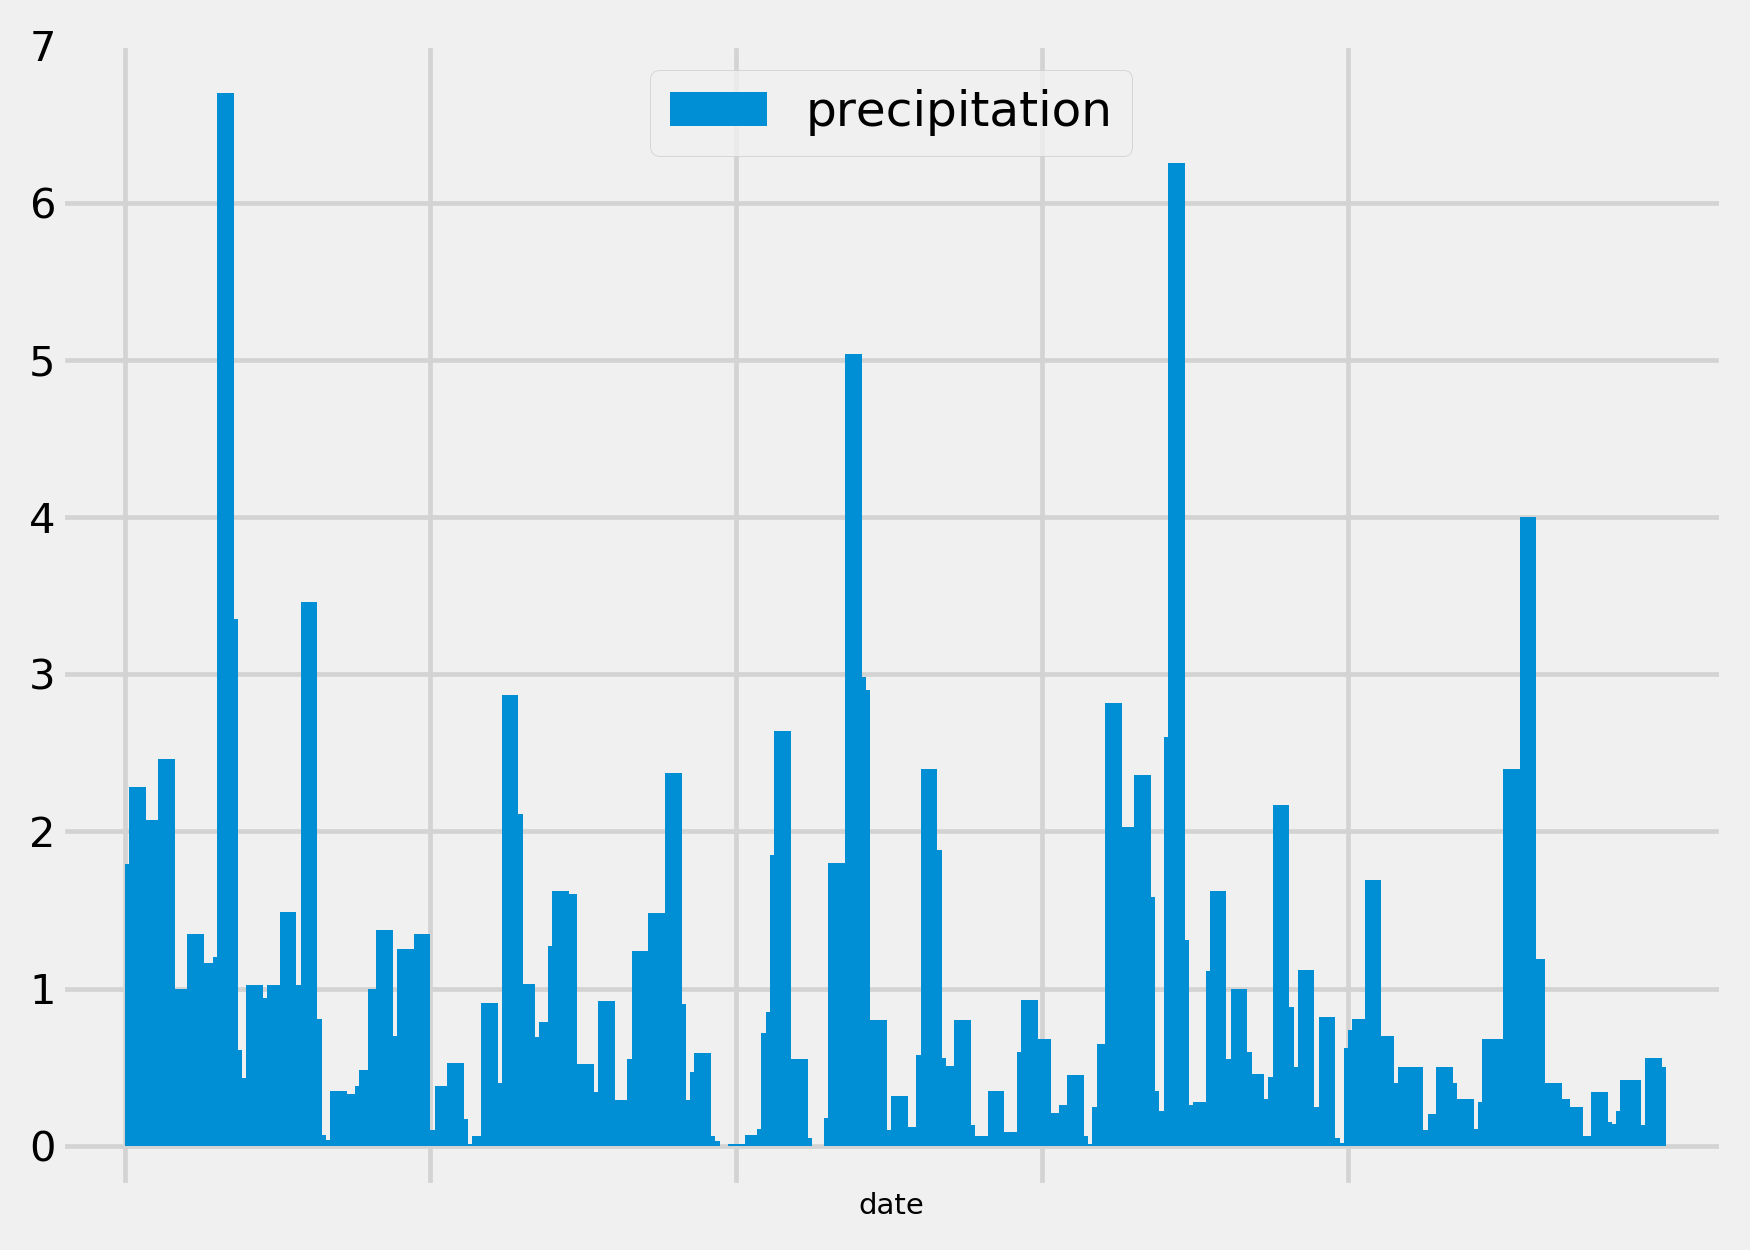

In [13]:
%matplotlib notebook

# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime as dt
from datetime import datetime


# Calculate the date 1 year ago from the last data point in the database
last_date1 = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(5).all()
last_date2 = [date[0] for date in last_date1]
last_date3 = last_date2[0]
last_date = dt.datetime.strptime(last_date3, '%Y-%m-%d')
query_dateline = dt.date(last_date.year, last_date.month, last_date.day) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, func.max(Measurement.prcp)).filter(Measurement.date >= query_dateline).\
          filter(Measurement.prcp != None).group_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql_query(results, session.bind)
df_prcp_index = df_prcp.set_index(['date'])

# Sort the dataframe by date
df_prcp_sort = df_prcp_index.sort_values(by=['date'],ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

#pos1 = ax.get_position() # get the original position
#pos2 = [pos1.x0-0.06, pos1.y0-0.05, pos1.width*1.5, pos1.height*1.5] 
#ax.set_position(pos2) # set a new position

df_prcp_sort.iloc[0:-1].plot(ax = ax, kind='bar', width=4, align='edge',joinstyle='round', stacked=True)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax.locator_params(axis='x', nbins=5)

ax.set_xlim(-15, len(df_prcp_sort)+15)
ax.set_ylim(-0.25, 7)

ax.grid(linewidth=2.7, color='lightgrey')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 24)

#Dealing with legend
import matplotlib.patches as mpatches
patch = mpatches.Patch(label='precipitation')
plt.legend(handles=[patch], bbox_to_anchor=(0.5, 1), loc='upper center', fontsize=28)

# Adjust layout
#ax.get_figure().tight_layout()
ax.get_figure().subplots_adjust(top=0.75)

plt.tight_layout(pad=1.2)
plt.show()
fig.savefig("Images/my_precipitation.png")

# Exploratory Climate Analysis

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_stat = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_dateline).statement

df_prcp_stat = pd.read_sql_query(results_stat, session.bind)

df_prcp_stat = df_prcp_stat.rename(columns={'prcp':'precipitation'})

df_prcp_stat.describe()



,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).statement

df_stations_count = pd.read_sql_query(stations, session.bind)

df_stations_count = df_stations_count.rename(columns={'count_1':'counts'})

print(df_stations_count)


       station  counts
0  USC00511918    1979
1  USC00513117    2709
2  USC00514830    2202
3  USC00516128    2612
4  USC00517948    1372
5  USC00518838     511
6  USC00519281    2772
7  USC00519397    2724
8  USC00519523    2669


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_stations_count_sort = df_stations_count.sort_values(by=['counts'], ascending=False)
df_stations_count_sort = df_stations_count_sort.reset_index(drop=True)
print(df_stations_count_sort)

       station  counts
0  USC00519281    2772
1  USC00519397    2724
2  USC00513117    2709
3  USC00519523    2669
4  USC00516128    2612
5  USC00514830    2202
6  USC00511918    1979
7  USC00517948    1372
8  USC00518838     511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#first_row = session.query(Measurement).first()
#first_row.__dict__

stations_tobs = session.query(Measurement.station, func.min(Measurement.tobs), \
                         func.max(Measurement.tobs), func.avg(Measurement.tobs), \
                              func.count(Measurement.tobs)).group_by(Measurement.station).statement

#load data into dataframe
df_station_tobs = pd.read_sql_query(stations_tobs, session.bind)

#change column names
df_station_tobs = df_station_tobs.rename(columns={'min_1':'lowest tobs', \
                                                  'max_1':'highest tobs',\
                                                  'avg_1':'avg tobs',\
                                                  'count_1':'tobs counts'})

#sort by station counts and reset index
df_station_tobs = df_station_tobs.sort_values(['tobs counts'], ascending=False)
df_station_tobs = df_station_tobs.reset_index(drop=True)

#display on screen
print(df_station_tobs)

       station  lowest tobs  highest tobs   avg tobs  tobs counts
0  USC00519281         54.0          85.0  71.663781         2772
1  USC00519397         56.0          87.0  74.553231         2724
2  USC00513117         59.0          85.0  72.689184         2709
3  USC00519523         56.0          85.0  74.543649         2669
4  USC00516128         58.0          84.0  70.915008         2612
5  USC00514830         58.0          85.0  74.873297         2202
6  USC00511918         53.0          87.0  71.615968         1979
7  USC00517948         58.0          87.0  74.684402         1372
8  USC00518838         58.0          83.0  72.724070          511


<IPython.core.display.Javascript object>


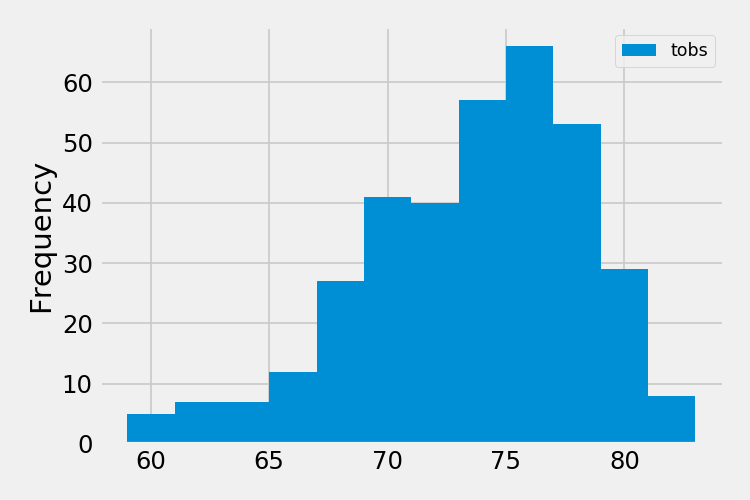

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

one_station = session.query(Measurement.tobs).filter(Measurement.date >= query_dateline).\
filter(Measurement.station=='USC00519281').statement

df_one_station = pd.read_sql_query(one_station, session.bind)

fig, ax = plt.subplots(figsize=(6,4))

bins = 12
ax.hist(df_one_station['tobs'], bins)

ax.legend(prop={'size': 10})

plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
fig.savefig("Images/my_station-histogram.png")

![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-08-01'
end_date = '2017-08-12'


temperature_status = calc_temps(start_date, end_date)

tmin = temperature_status[0][0]
tmax = temperature_status[0][2]
tavg = temperature_status[0][1]

print("---Temperature status in Honolulu during same days of previous year---")
print()
print(f"      Lowest: {tmin}")
print(f"      Average: {tavg}")
print(f"      Highest: {tmax}")


---Temperature status in Honolulu during same days of previous year---

      Lowest: 71.0
      Average: 78.93478260869566
      Highest: 83.0


<IPython.core.display.Javascript object>


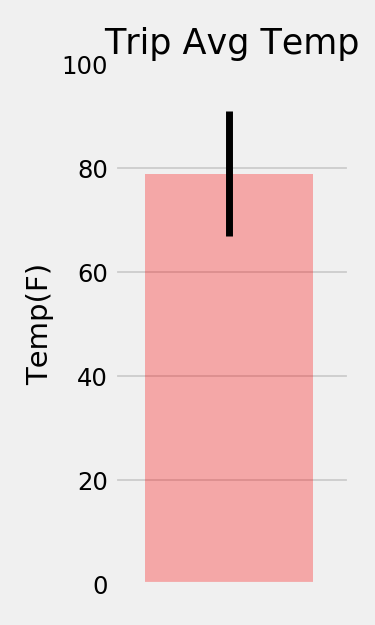

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,5))

x = [0.5]
#upper_error = tmax-tavg
#lower_error = tavg-tmin

plt.bar(x, tavg, 0.7, yerr=[tmax-tmin], alpha=0.3, color='r')

#plt.axis('off')
plt.title("Trip Avg Temp")

plt.xticks([])
plt.xlim(0.02,1)
plt.ylim(0,100)
plt.ylabel("Temp(F)")

#plt.tight_layout(pad=0.05)
#plt.subplots_adjust(top=1.5)

#plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig("Images/my_temperature.png")

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


rainfalls = session.query(Measurement.station, func.sum(Measurement.prcp),\
                          Station.name, Station.latitude, Station.longitude, Station.elevation ).\
                          filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
                          filter(Measurement.date <= end_date).group_by(Measurement.station).statement

df_rainfalls = pd.read_sql_query(rainfalls, session.bind)

df_rainfalls = df_rainfalls.rename(columns={'sum_1':'precipitation'})

df_rainfalls_sort = df_rainfalls.sort_values(by=['precipitation'], ascending=False)

df_rainfalls_sort = df_rainfalls_sort.reset_index(drop=True)

print(f"---Rainfall per weather station during {start_date} and {end_date} of the previous year---")
print()
print(df_rainfalls_sort)

---Rainfall per weather station during 2017-08-01 and 2017-08-12 of the previous year---

       station  precipitation                                    name  \
0  USC00516128           1.06            MANOA LYON ARBO 785.2, HI US   
1  USC00514830           0.32  KUALOA RANCH HEADQUARTERS 886.9, HI US   
2  USC00519281           0.06                     WAIHEE 837.5, HI US   
3  USC00519397           0.04                    WAIKIKI 717.2, HI US   
4  USC00519523           0.00      WAIMANALO EXPERIMENTAL FARM, HI US   

   latitude  longitude  elevation  
0  21.33310 -157.80250      152.4  
1  21.52130 -157.83740        7.0  
2  21.45167 -157.84889       32.9  
3  21.27160 -157.81680        3.0  
4  21.33556 -157.71139       19.5  


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

# Use the start and end date to create a range of dates
days_count = abs((end_date_dt-start_date_dt).days)+1
print(f"--- This is a {days_count} days trip ---")
print()

# Stip off the year and save a list of %m-%d strings
dates = []
date_dt = start_date_dt
date_year = date_dt.year

for i in range(0, days_count):
    date_next_dt = dt.date(date_year, date_dt.month, date_dt.day) + dt.timedelta(days=1)
    
    date_str = dt.datetime.strftime(date_dt, "%m-%d")
    dates.append(date_str)
    
    date_dt = date_next_dt

    #print(dates[i])
    

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for i in range(0, len(dates)):
    normal = daily_normals(dates[i])
    normals.append(normal[0])
    #print(normals[i])

    
for i in range(0, len(dates)):
    print(f"{i}   {dates[i]}   {normals[i]}")

--- This is a 12 days trip ---

0   08-01   (67.0, 75.54, 83.0)
1   08-02   (68.0, 75.60377358490567, 84.0)
2   08-03   (70.0, 76.61111111111111, 85.0)
3   08-04   (69.0, 76.71153846153847, 84.0)
4   08-05   (69.0, 76.14814814814815, 82.0)
5   08-06   (67.0, 76.25, 83.0)
6   08-07   (71.0, 77.15686274509804, 83.0)
7   08-08   (68.0, 76.5576923076923, 83.0)
8   08-09   (69.0, 75.98039215686275, 81.0)
9   08-10   (65.0, 76.42, 83.0)
10   08-11   (67.0, 75.98113207547169, 82.0)
11   08-12   (67.0, 76.52727272727273, 83.0)


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])

normals_df['date'] = dates

normals_df['date']= normals_df.set_index(['date'], drop=True, inplace=True)

if ('date' in normals_df.columns):
    del normals_df['date']

print(normals_df)
#print(normals_df.head())
#print(normals_df.index)

       tmin       tavg  tmax
date                        
08-01  67.0  75.540000  83.0
08-02  68.0  75.603774  84.0
08-03  70.0  76.611111  85.0
08-04  69.0  76.711538  84.0
08-05  69.0  76.148148  82.0
08-06  67.0  76.250000  83.0
08-07  71.0  77.156863  83.0
08-08  68.0  76.557692  83.0
08-09  69.0  75.980392  81.0
08-10  65.0  76.420000  83.0
08-11  67.0  75.981132  82.0
08-12  67.0  76.527273  83.0


<IPython.core.display.Javascript object>


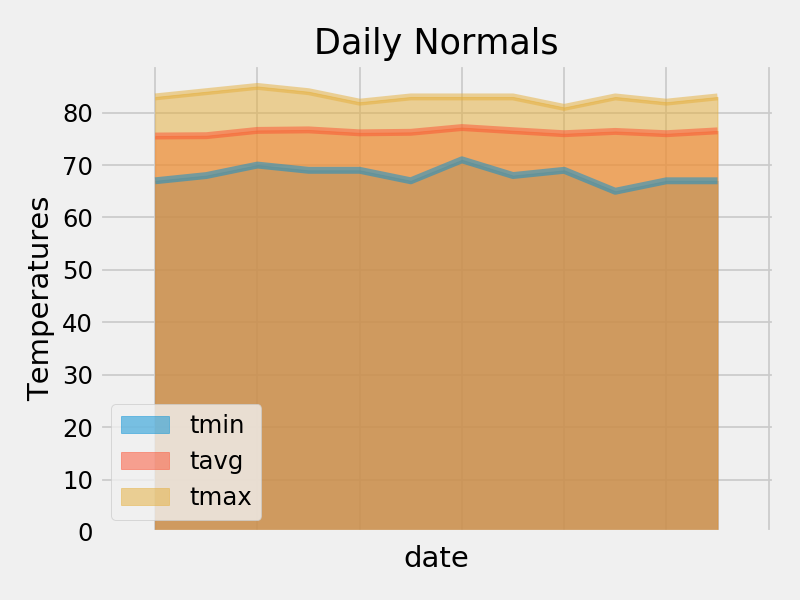

In [33]:
# Plot the daily normals as an area plot with `stacked=False`

#%matplotlib notebook

ax = normals_df.plot(kind='area', stacked=False, title='Daily Normals')

ax.set_ylabel('Temperatures')

ax.margins(0.1, 0.1) # Set margins to avoid "whitespace"

plt.tight_layout()
plt.show()
plt.savefig("Images/my_dailynormals.png")